<a href="https://colab.research.google.com/github/arqavan94/Persian_NLP_Task/blob/main/LSTM_othertags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation, SimpleRNN,GRU,Dropout,Conv1D, MaxPooling1D
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import pickle as pkl
from keras import metrics
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Prepare Data**

In [ ]:
text_labels= np.load('/content/drive/MyDrive/text_labels.npz', allow_pickle=True)
text_labels.files
text_labels= text_labels['arr_0']

**Split tags**

In [ ]:
words, tags = set(), set()
for sent in text_labels:
    for word, tag in sent:
      if tag not in ('ADVe','AJe','CONJe','DETe','NUMe','Ne','PROe','Pe','RESe','Ve'):
          words.add(word)
          tags.add(tag) 

# **Convert to number**

In [ ]:
word2idx = {w: i + 2 for i, w in enumerate(list(words))}
word2idx['PAD'] = 0
word2idx['UNK'] = 1
tag2idx = {t: i+1 for i, t in enumerate(list(tags))}
idx2word = {i + 2: w for i, w in enumerate(list(words))}
idx2tag = {i+1: t for i, t in enumerate(list(tags))}
tag2idx['<PAD>'] = 0

In [ ]:
X=[]
y =[]
for sent in text_labels:
  word2idxlist , tag2idxlist =[],[]
  flag= False
  for w,t in sent:
    if t not in ('ADVe','AJe','CONJe','DETe','NUMe','Ne','PROe','Pe','RESe','Ve'):
      word2idxlist.append(word2idx[w])
      tag2idxlist.append(tag2idx[t])
      flag=True
  if flag:
    X.append(word2idxlist)
    y.append(tag2idxlist)

In [ ]:
lengths=[len(seq) for seq in X]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 991


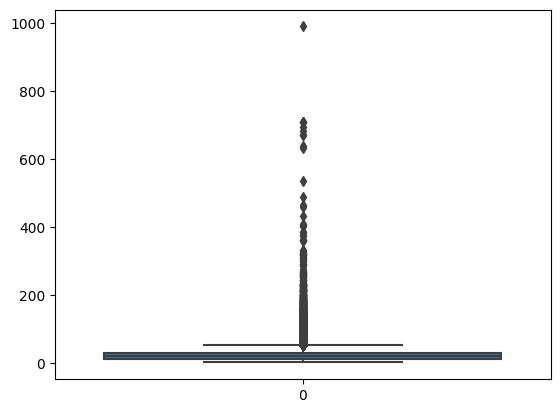

In [ ]:
sns.boxplot(lengths)
plt.show()

# **Pad sequences**

In [ ]:
max_len = 120
X = pad_sequences(X, maxlen=max_len, padding='post')
y = pad_sequences(y, maxlen=max_len, padding='post')

# **Convert to categorical (one_hot)**

In [ ]:
Y_cat = tf.keras.utils.to_categorical(y)

# **Split data to train, test, validation**

In [ ]:
# split train , test
(X_train, X_test, y_train, y_test) = train_test_split(X, Y_cat, test_size=0.2, random_state=42)

#split train in to train , vlaidation
(X_train, X_validation, y_train, y_validation) = train_test_split(X_train, y_train, test_size=0.2,random_state=42)

# **Save data as pickle**

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/X_train.pkl", "wb") as f:
    pkl.dump(X_train,f) 

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/X_test.pkl", "wb") as f:
    pkl.dump(X_test,f) 

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/y_train.pkl", "wb") as f:
    pkl.dump(y_train,f) 

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/y_test.pkl", "wb") as f:
    pkl.dump(y_test,f) 

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/y_validation.pkl", "wb") as f:
    pkl.dump(y_validation,f) 

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/X_validation.pkl", "wb") as f:
    pkl.dump(X_validation,f)

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/words.pkl", "wb") as f:
    pkl.dump(words,f)

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/tags.pkl", "wb") as f:
    pkl.dump(tags,f)

In [ ]:
set(tags)

{'ADV',
 'AJ',
 'CL',
 'CONJ',
 'DET',
 'INT',
 'N',
 'NUM',
 'P',
 'POSTP',
 'PRO',
 'PUNC',
 'RES',
 'V'}

# **Load Data**

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/X_train.pkl", "rb") as f:
    X_train= pkl.load(f)

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/X_test.pkl", "rb") as f:
    X_test= pkl.load(f)

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/y_train.pkl", "rb") as f:
    y_train= pkl.load(f)

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/y_test.pkl", "rb") as f:
    y_test= pkl.load(f)

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/X_validation.pkl", "rb") as f:
    X_validation= pkl.load(f)

with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/y_validation.pkl", "rb") as f:
    y_validation= pkl.load(f)

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/words.pkl", "rb") as f:
    words= pkl.load(f)

In [ ]:
with open("/content/drive/MyDrive/roshan_sent_tag_data/new_data_tags/tags.pkl", "rb") as f:
    tags= pkl.load(f)

# **LSTM**

In [ ]:
from keras.optimizers.legacy.gradient_descent import SGD
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim = len(words) + 2, output_dim= 100, 
                        input_length= 120))

lstm_model.add(LSTM(32, return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(TimeDistributed(Dense(len(tags)+1)))
lstm_model.add(Activation('softmax'))
 
lstm_model.compile(loss='categorical_crossentropy',
              optimizer= SGD(0.05),
              metrics=[metrics.categorical_accuracy])
 
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 100)          13063600  
                                                                 
 lstm (LSTM)                 (None, 120, 32)           17024     
                                                                 
 dropout (Dropout)           (None, 120, 32)           0         
                                                                 
 time_distributed (TimeDistr  (None, 120, 15)          495       
 ibuted)                                                         
                                                                 
 activation (Activation)     (None, 120, 15)           0         
                                                                 
Total params: 13,081,119
Trainable params: 13,081,119
Non-trainable params: 0
____________________________________________

In [ ]:
lstm_history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32,
                      validation_data=(X_validation, y_validation), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')])

Epoch 1/100
6895/6895 [==============================] - 68s 9ms/step - loss: 0.3978 - categorical_accuracy: 0.8717 - val_loss: 0.3373 - val_categorical_accuracy: 0.8887
Epoch 2/100
6895/6895 [==============================] - 58s 8ms/step - loss: 0.2736 - categorical_accuracy: 0.9193 - val_loss: 0.2098 - val_categorical_accuracy: 0.9345
Epoch 3/100
6895/6895 [==============================] - 60s 9ms/step - loss: 0.1961 - categorical_accuracy: 0.9393 - val_loss: 0.1612 - val_categorical_accuracy: 0.9503
Epoch 4/100
6895/6895 [==============================] - 61s 9ms/step - loss: 0.1566 - categorical_accuracy: 0.9507 - val_loss: 0.1278 - val_categorical_accuracy: 0.9592
Epoch 5/100
6895/6895 [==============================] - 62s 9ms/step - loss: 0.1284 - categorical_accuracy: 0.9595 - val_loss: 0.1045 - val_categorical_accuracy: 0.9660
Epoch 6/100
6895/6895 [==============================] - 57s 8ms/step - loss: 0.1084 - categorical_accuracy: 0.9652 - val_loss: 0.0881 - val_categoric

In [ ]:
lstm_model.save('/content/drive/MyDrive/roshan_sent_tag_data/models/lstm_model_othertags.h5')

In [ ]:
lstm_model= tf.keras.models.load_model('/content/drive/MyDrive/roshan_sent_tag_data/models/lstm_model_othertags.h5')

**Visualizing Training History**

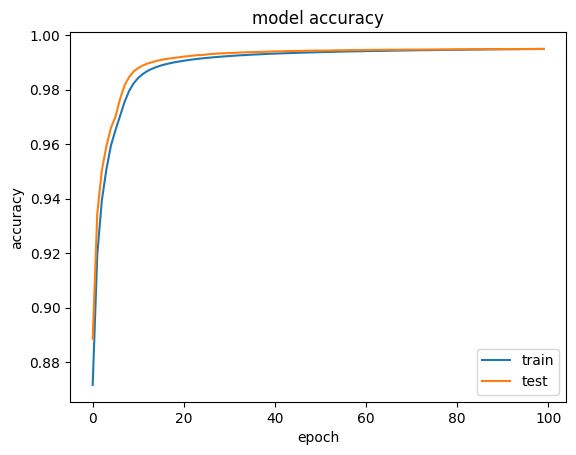

In [ ]:
#lstm_model
plt.plot(lstm_history.history['categorical_accuracy'])
plt.plot(lstm_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train' , 'test'], loc= "lower right")
plt.show()

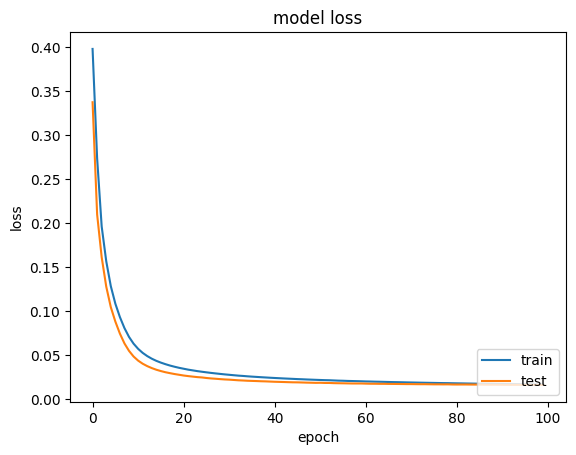

In [ ]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train' , 'test'], loc= "lower right")
plt.show()

**Performance_Evaluation**

In [ ]:
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print("LSTM_Model \nLoss: {0}, \nTestAccuracy: {1}".format(loss, accuracy))

2155/2155 [==============================] - 17s 5ms/step - loss: 0.0162 - categorical_accuracy: 0.9949
LSTM_Model 
Loss: 0.016239024698734283, 
TestAccuracy: 0.9948663115501404


**Classification Report**

In [ ]:
from sklearn.metrics import classification_report

y_pred = lstm_model.predict(X_test)

y_pred2 = np.argmax(y_pred, axis=-1)

y_true = np.argmax(y_test, axis=-1)

tags = ['ADV','AJ','CL','CONJ','DET','INT','N','NUM','P','POSTP','PRO','PUNC','RES','V','PAD']

2155/2155 [==============================] - 8s 4ms/step


In [ ]:
set(y_pred2.flatten())

{0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14}

In [ ]:
report = classification_report(y_true.flatten(), y_pred2.flatten(),target_names=tags)
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADV       1.00      1.00      1.00   6779188
          AJ       0.88      0.92      0.90     44060
          CL       0.91      0.70      0.79      6708
        CONJ       0.92      0.93      0.93    134735
         DET       0.97      0.98      0.97    412533
         INT       1.00      0.99      1.00     28594
           N       0.00      0.00      0.00       148
         NUM       1.00      1.00      1.00    186304
           P       0.77      0.58      0.66      4193
       POSTP       0.94      0.88      0.91     35452
         PRO       0.99      0.99      0.99    174311
        PUNC       0.99      1.00      0.99    197030
         RES       0.99      0.99      0.99    165612
           V       0.99      0.98      0.98     53789
         PAD       0.92      0.90      0.91     50503

    accuracy                           0.99   8273160
   macro avg       0.88      0.86      0.87   8273160
weighted avg       0.99   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
